<a href="https://colab.research.google.com/github/1rd0/18lab_bek/blob/master/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install diffusers
!pip install accelerate
!pip install transformers

In [3]:
import torch
from PIL import Image
import requests
from matplotlib import pyplot as plt
from transformers import (
  BlipForConditionalGeneration,
  BlipProcessor,
)
from transformers import (
  AutoModelForCausalLM,
  AutoTokenizer,
  Owlv2ForObjectDetection,
  Owlv2Processor,
  SamModel,
  SamProcessor,
)
from diffusers import AutoPipelineForInpainting

/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)


In [4]:
IMAGE_URL = "https://cdn-ilaapph.nitrocdn.com/JrvKYXUyXJpBMceqqelMgdRXClAyUWPy/assets/images/optimized/rev-07fee98/beeswiki.com/wp-content/uploads/2022/01/How-Many-Legs-Do-Bees-Have-e1642527581666.png"
OBJECT_TO_DEL="Bee"
EDIT_PROMPT = "Bird"
SEED_VALUE = 41
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
GENERATOR = torch.Generator().manual_seed(SEED_VALUE)


In [5]:
class Config:
  IMAGE_SIZE = (512, 512)
  LANGUAGE_MODEL_ID = "Qwen/Qwen1.5-0.5B-Chat"
  CAPTION_MODEL_ID = "Salesforce/blip-image-captioning-base"
  DETECTION_MODEL_ID = "google/owlv2-base-patch16-ensemble"
  SEGMENTATION_MODEL_ID = "facebook/sam-vit-base"
  INPAINTING_MODEL_ID = "diffusers/stable-diffusion-xl-1.0-inpainting0.1"
config = Config()

In [6]:
def delete_model(model: torch.nn.Module):
  model.to("cpu")
  del model
  torch.cuda.empty_cache()

In [7]:
def load_image(image_url, image_size = (512, 512)):
  raw_image = Image.open(requests.get(image_url,stream=True).raw).convert("RGB")
  image = raw_image.resize(image_size)
  return image

In [8]:
image = load_image(image_url=IMAGE_URL,
image_size=config.IMAGE_SIZE)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


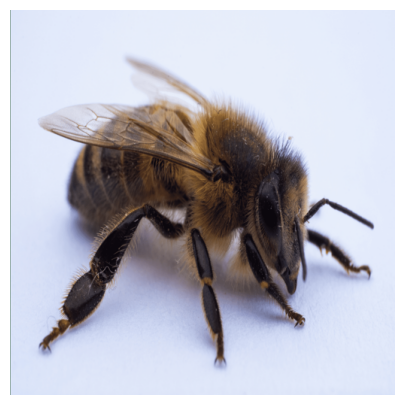

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

In [10]:
def run_caption_model(model_id: str, image: Image, device: str = "cuda"):
  caption_model =BlipForConditionalGeneration.from_pretrained(model_id).to(device)
  caption_processor = BlipProcessor.from_pretrained(model_id)
  inputs = caption_processor(image, return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = caption_model.generate(**inputs, max_new_tokens=50)
  caption = caption_processor.decode(outputs[0],
  skip_special_tokens=True)
  delete_model(caption_model)
  return caption


In [11]:
def run_segmentation_pipeline(
    detection_model_id: str,
    segmentation_model_id: str,
    to_replace: str,
    image: Image,
    device: str = "cuda",
):
    processor = Owlv2Processor.from_pretrained(detection_model_id)
    od_model = Owlv2ForObjectDetection.from_pretrained(detection_model_id).to(device)
    text_queries = [to_replace]
    inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = od_model(**inputs)

    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]
    boxes = results["boxes"].tolist()

    delete_model(od_model)

    seg_model = SamModel.from_pretrained(segmentation_model_id).to(device)
    processor = SamProcessor.from_pretrained(segmentation_model_id)
    input_boxes = [boxes]
    inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = seg_model(**inputs)

    mask = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu(),
    )[0]

    mask = torch.max(mask[:, 0, ...], dim=0, keepdim=False).values
    segmentation_mask = Image.fromarray(mask.numpy())

    delete_model(seg_model)

    return segmentation_mask

In [12]:
segmentation_mask = run_segmentation_pipeline(
  detection_model_id=config.DETECTION_MODEL_ID,
  segmentation_model_id=config.SEGMENTATION_MODEL_ID,
  to_replace=OBJECT_TO_DEL,
  image=image,
  device=DEVICE,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
print("#"*100)
print(f"Using detection model: {config.DETECTION_MODEL_ID}")
print(f"Using segmentation model: {config.SEGMENTATION_MODEL_ID}")
print("#"*100)

####################################################################################################
Using detection model: google/owlv2-base-patch16-ensemble
Using segmentation model: facebook/sam-vit-base
####################################################################################################


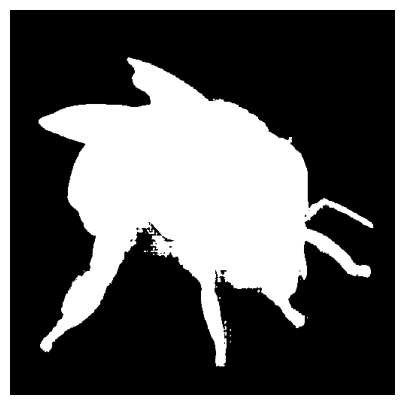

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(segmentation_mask)
plt.axis("off")
plt.show()


In [15]:
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid
pipeline = AutoPipelineForInpainting.from_pretrained(
"kandinsky-community/kandinsky-2-2-decoder-inpaint",torch_dtype=torch.float16
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
init_image = image
mask_image = segmentation_mask
prompt = EDIT_PROMPT
negative_prompt = "bad anatomy, deformed, ugly, disfigured"


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


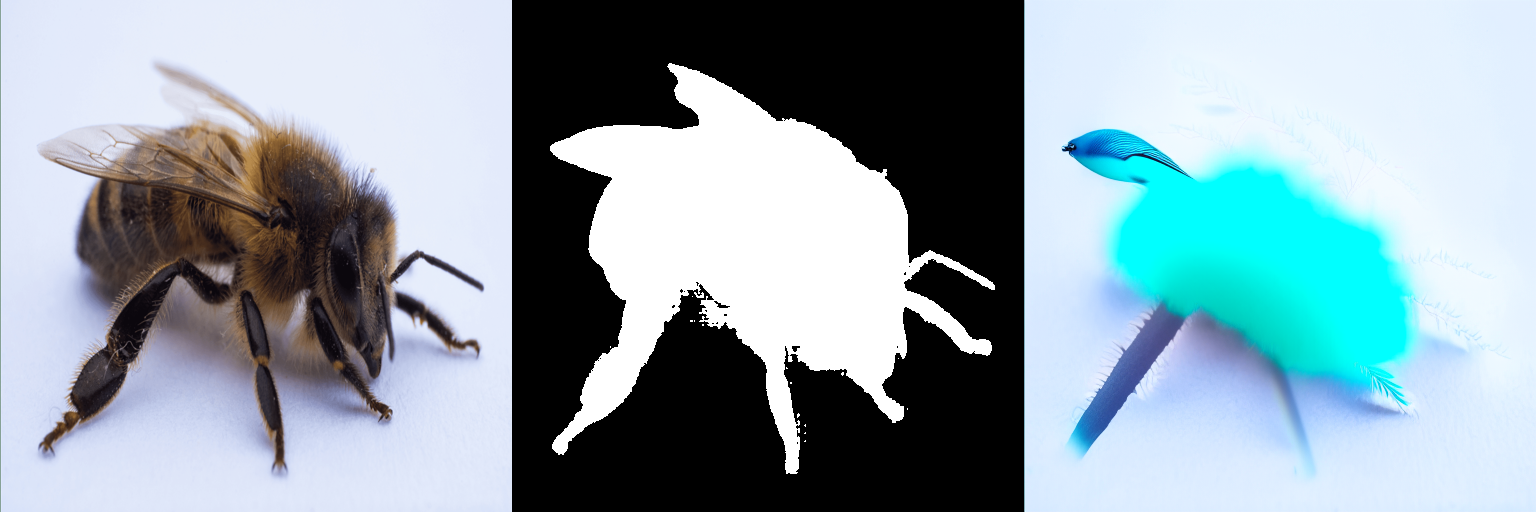

In [17]:
image2 = pipeline(prompt=prompt, negative_prompt=negative_prompt,
image=init_image, mask_image=mask_image).images[0]
make_image_grid([init_image, mask_image, image2], rows=1, cols=3)

In [ ]:
pipeline = AutoPipelineForInpainting.from_pretrained(
"diffusers/stable-diffusion-xl-1.0-inpainting-0.1",torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
image2 = pipeline(prompt=prompt, negative_prompt=negative_prompt,
image=init_image, mask_image=mask_image).images[0]
make_image_grid([init_image, mask_image, image2], rows=1, cols=3)